In [1]:
 ! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import opendatasets
opendatasets.download(
	"https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/download?datasetVersionNumber=2",force = True)

100%|██████████| 2.29G/2.29G [01:45<00:00, 23.4MB/s]


In [7]:
import cv2
from google.colab.patches import cv2_imshow as ci
image = cv2.imread("/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print(image.shape)

(1858, 2090, 3)


In [8]:
import cv2
import os
from tqdm import tqdm
import numpy as np
image_categories = ['PNEUMONIA', 'NORMAL']
image_size = 128
def load_images_from_folder(all_images_folder_path):
  all_images = [] 
  all_labels = []
  for cat in tqdm(image_categories): 
    cat_path = os.path.join(all_images_folder_path, cat)
    for image in os.listdir(cat_path):
      try:
        image = cv2.imread(os.path.join(cat_path, image), cv2.IMREAD_GRAYSCALE)
        image_resized = cv2.resize(image, (image_size, image_size)) 
        all_images.append(image_resized)
        all_labels.append(cat)
      except Exception as e:
        print("the error while loading image is", e)
  return all_images,all_labels

In [9]:
images_train,labels_train = load_images_from_folder("/content/chest-xray-pneumonia/chest_xray/chest_xray/train")

  0%|          | 0/2 [00:00<?, ?it/s]

the error while loading image is OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 50%|█████     | 1/2 [00:17<00:17, 17.73s/it]

the error while loading image is OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 2/2 [00:41<00:00, 20.73s/it]


In [10]:
images_val,labels_val = load_images_from_folder("/content/chest-xray-pneumonia/chest_xray/chest_xray/val")

100%|██████████| 2/2 [00:00<00:00, 15.43it/s]

the error while loading image is OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

the error while loading image is OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [11]:
images_test,labels_test = load_images_from_folder("/content/chest-xray-pneumonia/chest_xray/chest_xray/test")

100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


<function matplotlib.pyplot.show(*args, **kw)>

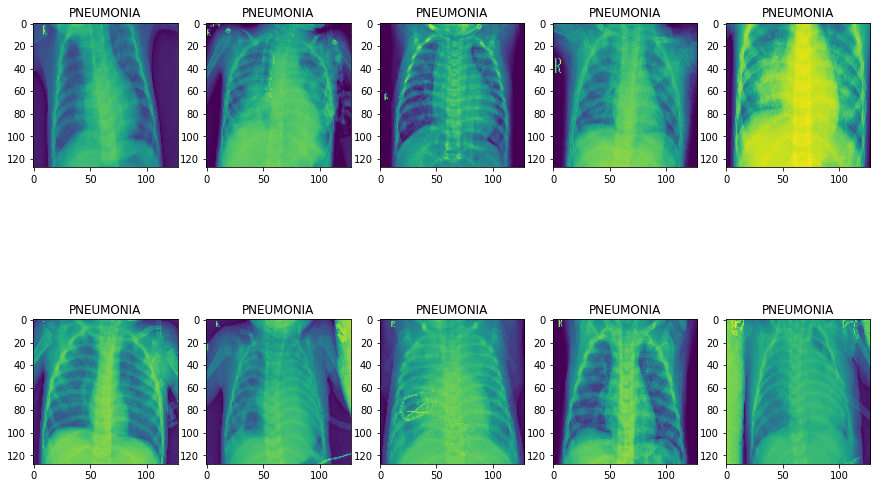

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images_train[i])
  plt.title(labels_train[i])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

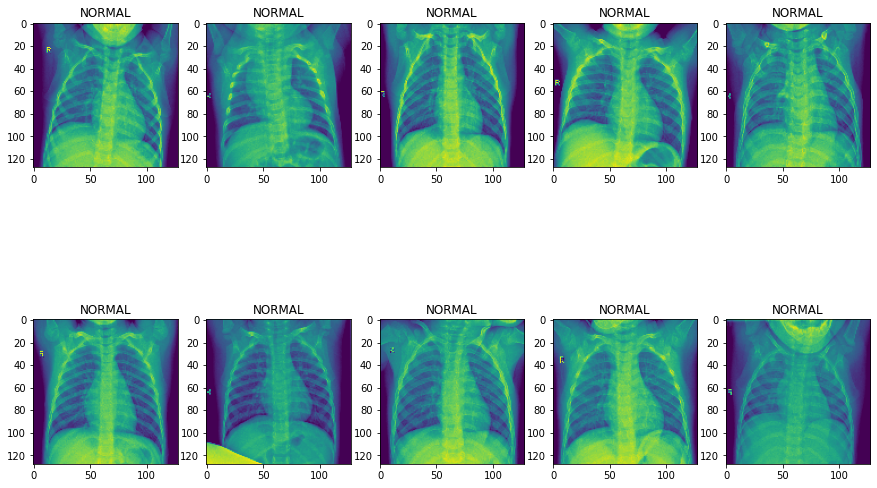

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
count = 0
for i in range(len(images_train)-10, len(images_train)):
  count+=1
  plt.subplot(2,5,count)
  plt.imshow(images_train[i])
  plt.title(labels_train[i])
plt.show

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


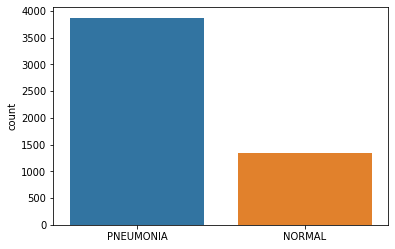

In [14]:
import seaborn as sns
sns.countplot(labels_train)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


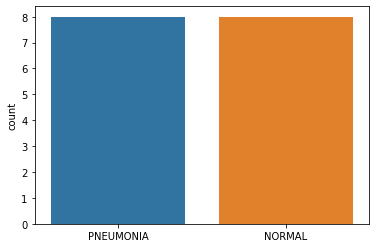

In [15]:
import seaborn as sns
sns.countplot(labels_val)

In [16]:
images_train.extend(images_val)
labels_train.extend(labels_val)
images_train = np.array(images_train)/255

In [17]:
labels_train_updated = []
for label in labels_train:
  if label == "PNEUMONIA":
    labels_train_updated.append(1)
  else:
    labels_train_updated.append(0)

In [18]:
images_train = np.array(images_train).reshape(-1, image_size, image_size, 1)
labels_train_updated = np.array(labels_train_updated)

In [19]:
from sklearn.model_selection import train_test_split
images_tr, images_cv, labels_tr, labels_cv = train_test_split(images_train, labels_train_updated, test_size=0.25,stratify = labels_train_updated, random_state=20)

In [20]:
labels_tr = np.array(labels_tr)
labels_cv= np.array(labels_cv)

In [21]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True) 
datagen.fit(images_tr)

In [27]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=images_tr.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])


In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 128)     1280      
                                                                 
 activation_13 (Activation)  (None, 128, 128, 128)     0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 128)      256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 activation_14 (Activation)  (None, 64, 64, 64)       

In [28]:
history = model. fit(datagen.flow(images_tr, labels_tr, batch_size=64), callbacks=[early_stop], validation_data=(images_cv, labels_cv), epochs = 50)

Epoch 1/50
62/62 [==============================] - 8s 126ms/step - loss: 0.6221 - acc: 0.7304 - val_loss: 0.6379 - val_acc: 0.7424
Epoch 2/50
62/62 [==============================] - 8s 120ms/step - loss: 0.4494 - acc: 0.7482 - val_loss: 1.6593 - val_acc: 0.7424
Epoch 3/50
62/62 [==============================] - 8s 122ms/step - loss: 0.3974 - acc: 0.7755 - val_loss: 2.4834 - val_acc: 0.7424
Epoch 4/50
62/62 [==============================] - 8s 121ms/step - loss: 0.3453 - acc: 0.8305 - val_loss: 2.9446 - val_acc: 0.7424
Epoch 5/50
62/62 [==============================] - 7s 120ms/step - loss: 0.3407 - acc: 0.8423 - val_loss: 3.2095 - val_acc: 0.7424
Epoch 6/50
62/62 [==============================] - 8s 121ms/step - loss: 0.3313 - acc: 0.8524 - val_loss: 2.7132 - val_acc: 0.7424
Epoch 7/50
62/62 [==============================] - 8s 120ms/step - loss: 0.3091 - acc: 0.8624 - val_loss: 1.5802 - val_acc: 0.7424
Epoch 8/50
62/62 [==============================] - 7s 120ms/step - loss: 0.

40

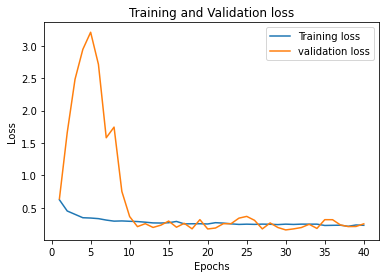

In [32]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_val)+1)
plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

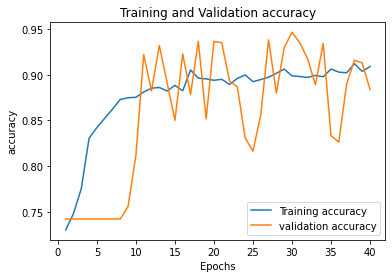

In [33]:
accuracy_train = history.history['acc']
accuracy_val = history.history['val_acc']
epochs = range(1,len(accuracy_val)+1)
plt.plot(epochs, accuracy_train, label='Training accuracy')
plt.plot(epochs, accuracy_val, label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model.save("Best_model.h5")

In [ ]:
model = tf.keras.models.load_model('/content/Best_model.h5')

In [34]:
images_test = np.array(images_test)/255

In [35]:
test_labels_updated = []
for label in labels_test:
  if label == "PNEUMONIA":
    test_labels_updated.append(1)
  else:
    test_labels_updated.append(0)


In [37]:
test_labels_updated = np.array(test_labels_updated)

In [36]:
images_test = np.array(images_test).reshape(-1, image_size, image_size, 1)

In [38]:
model.evaluate(images_test,test_labels_updated)

20/20 [==============================] - 1s 29ms/step - loss: 0.3651 - acc: 0.8686


[0.3651014268398285, 0.8685897588729858]

In [39]:
pred = model.predict(images_test)
predicted_test_labels = []
for val in pred:
  if val>0.5:
    predicted_test_labels.append(1)
  else:
    predicted_test_labels.append(0)

20/20 [==============================] - 0s 16ms/step


In [40]:
test_labels_updated = list(test_labels_updated)

In [42]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision score is",precision_score(test_labels_updated, predicted_test_labels))
print("recall score is", recall_score(test_labels_updated, predicted_test_labels))
print("F1 score is",f1_score(test_labels_updated, predicted_test_labels))

Precision score is 0.8362445414847162
recall score is 0.982051282051282
F1 score is 0.9033018867924528


In [76]:
from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [ ]:
for layer in vgg_model.layers[:13]:
    layer.trainable = False

In [77]:
x = vgg_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(256, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
transfer_model = tf.keras.Model(inputs=vgg_model.input, outputs=x)

In [69]:
transfer_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [78]:
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
transfer_model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [72]:
images_tr_ = np.ndarray(shape=(images_tr.shape[0], images_tr.shape[1], images_tr.shape[2], 3), dtype= np.uint8) 
images_cv_ = np.ndarray(shape=(images_cv.shape[0], images_cv.shape[1], images_cv.shape[2], 3), dtype= np.uint8) 

In [54]:
labels_tr = tf.keras.utils.to_categorical(labels_tr)
labels_cv = tf.keras.utils.to_categorical(labels_cv)

In [79]:
history = transfer_model.fit(datagen.flow(images_tr_, labels_tr, batch_size=64), callbacks=[early_stop], validation_data=(images_cv_, labels_cv), epochs = 50)

Epoch 1/50
62/62 [==============================] - 19s 298ms/step - loss: 0.5902 - acc: 0.7388 - val_loss: 1.8031 - val_acc: 0.7424
Epoch 2/50
62/62 [==============================] - 19s 306ms/step - loss: 0.5775 - acc: 0.7421 - val_loss: 1.9523 - val_acc: 0.7424
Epoch 3/50
62/62 [==============================] - 18s 295ms/step - loss: 0.5748 - acc: 0.7421 - val_loss: 1.0974 - val_acc: 0.7424
Epoch 4/50
62/62 [==============================] - 18s 296ms/step - loss: 0.5769 - acc: 0.7421 - val_loss: 0.9757 - val_acc: 0.7424
Epoch 5/50
62/62 [==============================] - 18s 294ms/step - loss: 0.5739 - acc: 0.7421 - val_loss: 0.7945 - val_acc: 0.7424
Epoch 6/50
62/62 [==============================] - 18s 296ms/step - loss: 0.5778 - acc: 0.7421 - val_loss: 0.6271 - val_acc: 0.7164
Epoch 7/50
62/62 [==============================] - 19s 298ms/step - loss: 0.5753 - acc: 0.7421 - val_loss: 0.6095 - val_acc: 0.7408
Epoch 8/50
62/62 [==============================] - 19s 304ms/step - 

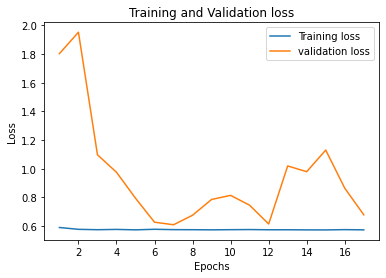

In [80]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_val)+1)
plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

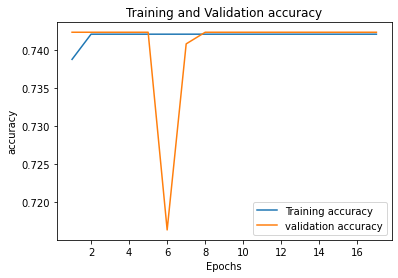

In [81]:
accuracy_train = history.history['acc']
accuracy_val = history.history['val_acc']
epochs = range(1,len(accuracy_val)+1)
plt.plot(epochs, accuracy_train, label='Training accuracy')
plt.plot(epochs, accuracy_val, label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [89]:
images_test = np.array(images_test)/255


In [92]:
test_labels_updated = []
for label in labels_test:
  if label == "PNEUMONIA":
    test_labels_updated.append(1)
  else:
    test_labels_updated.append(0)

In [95]:
test_labels_updated = np.array(test_labels_updated)

In [96]:
model.evaluate(images_test,test_labels_updated)
pred = model.predict(images_test)
predicted_test_labels = []
for val in pred:
  if val>0.5:
    predicted_test_labels.append(1)
  else:
    predicted_test_labels.append(0)
test_labels_updated = list(test_labels_updated)


print("Precision score is",precision_score(test_labels_updated, predicted_test_labels))
print("recall score is", recall_score(test_labels_updated, predicted_test_labels))
print("F1 score is",f1_score(test_labels_updated, predicted_test_labels))

20/20 [==============================] - 0s 14ms/step
Precision score is 0.625
recall score is 1.0
F1 score is 0.7692307692307693


In [98]:
confusion_matrix(test_labels_updated, predicted_test_labels)

array([[  0, 234],
       [  0, 390]])